**Fuzzy Inference System I - Event Classification \\
Fuzzy Inference System II - Fault Classification**

Author: Dionatan Cieslak

---



### Useful libraries

In [ ]:
!pip install networkx==2.3
!pip install scikit-fuzzy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import scipy.io as sio
import zipfile
import itertools
import glob
import os
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from natsort import natsorted
from google.colab import files
from sklearn.metrics import confusion_matrix
from google.colab import drive
drive.mount('/content/drive')

### Data preparation

In [ ]:
# Uploading files from g-drive:
with zipfile.ZipFile("/content/drive/My Drive/PSCC 2022/matRuido.zip", "r") as zip_ref:
  zip_ref.extractall(".")
!mkdir npyData

# Converting .mat files into .npy:
files = []
start_dir = "/content/matRuido"
pattern   = "*.mat"
for dir,_,_ in os.walk(start_dir):
    files.extend(glob.glob(os.path.join(dir,pattern)))
data_path = files
for d_path in data_path:
    base = os.path.basename(d_path)
    fileID = os.path.splitext(base)[0]
    # load mat file (the loaded file is in the dictionary file)
    mat_contents = sio.loadmat(d_path)
    # extract the data in a np array format
    temp_data = mat_contents['matrizCompSimetricas']
    # shaping from (120, 120, 6) to (14400, 6)
    data_righ_shape = temp_data.reshape(-1,temp_data.shape[2],order='F')
    # denormalize
    data_pu = data_righ_shape
    temp_v0, temp_v1, temp_v2 = data_pu[:,0], data_pu[:,1], data_pu[:,2]
    temp_i0, temp_i1, temp_i2 = data_pu[:,3], data_pu[:,4], data_pu[:,5]
    data_struct = np.array([[temp_v0],[temp_v1],[temp_v2],[temp_i0],[temp_i1],[temp_i2]])
    np.save('./npyData/' + fileID + '.npy', data_struct)

### Fuzzy Inference System I

FIS I is responsible for classificate the following classes:
- DESE01
- LINC02
- LDEC04
- SHUT04
- NOOP05


FIS I modelling:

In [ ]:
# Create fuzzy inputs universe:
v_pre = ctrl.Antecedent(np.arange(0, 1.2, 0.1), 'v_pre')
v_pos = ctrl.Antecedent(np.arange(0, 1.2, 0.1), 'v_pos')
i_pre = ctrl.Antecedent(np.arange(0, 1.2, 0.1), 'i_pre')
i_pos = ctrl.Antecedent(np.arange(0, 1.2, 0.1), 'i_pos')
i_var = ctrl.Antecedent(np.arange(-1.1, 1.1, 0.1), 'i_var')

# Create the mapping from crisp to fuzzy:
v_pre['null'] = fuzz.trapmf(v_pre.universe, [0, 0, 0.15, 0.25])
v_pre['intermediate'] = fuzz.trapmf(v_pre.universe, [0.15, 0.25, 0.65, 0.75])
v_pre['nominal'] = fuzz.trapmf(v_pre.universe, [0.65, 0.75, 1.2, 1.2])
# v_pre.view()
v_pos['null'] = fuzz.trapmf(v_pos.universe, [0, 0, 0.15, 0.25])
v_pos['intermediate'] = fuzz.trapmf(v_pos.universe, [0.15, 0.25, 0.65, 0.75])
v_pos['nominal'] = fuzz.trapmf(v_pos.universe, [0.65, 0.75, 1.2, 1.2])
# v_pos.view()
i_pre['null'] = fuzz.trapmf(i_pre.universe, [0, 0, 0.2, 0.3])
i_pre['intermediate'] = fuzz.trapmf(i_pre.universe, [0.2, 0.3, 0.6, 0.7])
i_pre['nominal'] = fuzz.trapmf(i_pre.universe, [0.6, 0.7, 1.2, 1.2])
# i_pre.view()
i_pos['null'] = fuzz.trapmf(i_pos.universe, [0, 0, 0.2, 0.3])
i_pos['intermediate'] = fuzz.trapmf(i_pos.universe, [0.2, 0.3, 0.6, 0.7])
i_pos['nominal'] = fuzz.trapmf(i_pos.universe, [0.6, 0.7, 1.2, 1.2])
# i_pos.view()
i_var['negative'] = fuzz.trapmf(i_var.universe, [-1.1, -1.1, -0.01, 0])
i_var['null'] = fuzz.trimf(i_var.universe, [-0.001, 0, 0.001])
i_var['positive'] = fuzz.trapmf(i_var.universe, [0, 0.01, 1.1, 1.1])
# i_var.view()

# Create fuzzy outputs universe:
operational_state = ctrl.Consequent(np.arange(0, 1.2, 0.01), 'operational_state')

# Create the mapping from crisp to fuzzy:
sigma = 0.1
c_des = 0.2
c_inc = 0.4
c_dec = 0.6
c_shu = 0.8
c_nop = 1.0
operational_state['desenergization'] = fuzz.gaussmf(operational_state.universe, c_des, sigma)
operational_state['load increase'] = fuzz.gaussmf(operational_state.universe, c_inc, sigma)
operational_state['load decrease'] = fuzz.gaussmf(operational_state.universe, c_dec, sigma)
operational_state['shutdown'] = fuzz.gaussmf(operational_state.universe, c_shu, sigma)
operational_state['normal operation'] = fuzz.gaussmf(operational_state.universe, c_nop, sigma)
# operational_state.view()

# Create set of rules:
rule1 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['nominal'] & i_pos['nominal'] & i_var['null'], operational_state['normal operation'])
rule2 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['intermediate'] & i_pos['intermediate'] & i_var['null'], operational_state['normal operation'])
rule3 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['null'] & i_pos['null'] & i_var['null'], operational_state['normal operation'])
rule4 = ctrl.Rule(v_pre['nominal'] & v_pos['null'] & i_pre['null'] & i_pos['null'] & i_var['null'], operational_state['desenergization'])
rule5 = ctrl.Rule(v_pre['nominal'] & v_pos['null'] & i_pre['null'] & i_pos['null'] & i_var['negative'], operational_state['desenergization'])
rule6 = ctrl.Rule(v_pre['nominal'] & v_pos['null'] & i_pre['nominal'] & i_pos['null'], operational_state['shutdown'])
rule7 = ctrl.Rule(v_pre['nominal'] & v_pos['null'] & i_pre['intermediate'] & i_pos['null'], operational_state['shutdown'])
rule8 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['nominal'] & i_pos['nominal'] & i_var['positive'], operational_state['load increase'])
rule9 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['null'] & i_pos['intermediate'] & i_var['positive'], operational_state['load increase'])
rule10 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['intermediate'] & i_pos['intermediate'] & i_var['positive'], operational_state['load increase'])
rule11 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['intermediate'] & i_pos['nominal'] & i_var['positive'] , operational_state['load increase'])
rule12 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['intermediate'] & i_pos['intermediate'] & i_var['negative'], operational_state['load decrease'])
rule13 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['nominal'] & i_pos['nominal'] & i_var['negative'], operational_state['load decrease'])
rule14 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['nominal'] & i_pos['intermediate'] & i_var['negative'], operational_state['load decrease'])
rule15 = ctrl.Rule(v_pre['nominal'] & v_pos['nominal'] & i_pre['intermediate'] & i_pos['null'] & i_var['negative'], operational_state['load decrease'])

# Create FIS I:
sif = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15])
sif_sim = ctrl.ControlSystemSimulation(sif)

# Function for inference:
def FIS(pre_voltage, post_voltage, pre_current, post_current, current_variation):
  sif_sim.input['v_pre'] = pre_voltage
  sif_sim.input['v_pos'] = post_voltage
  sif_sim.input['i_pre'] = pre_current
  sif_sim.input['i_pos'] = post_current
  sif_sim.input['i_var'] = current_variation
  sif_sim.compute()
  return round(sif_sim.output['operational_state'],4)

Inference process (classifying all records):

In [ ]:
npydata_path = glob.glob("./npyData/Fuzzy*.npy")
npydata_path = natsorted(npydata_path)
v1_pre_v, v1_pos_v, i1_pre_v, i1_pos_v = [],[],[],[]
memb_des_v, memb_shu_v, memb_dec_v, memb_inc_v, memb_nop_v = [], [],[],[],[]
results = []
for npyd_path in npydata_path:
  npydata = np.load(npyd_path)
  # flatten from (1, 14400) to (14400)
  v0, v1, v2 = npydata[0].flatten(), npydata[1].flatten(), npydata[2].flatten()
  i0, i1, i2 = npydata[3].flatten(), npydata[4].flatten(), npydata[5].flatten()
  # calculte mean values pre and post trigger (t = 34s = sample nº 2040)
  beg_tra = 2040
  end_tra = 2055
  v0_pre = np.mean(v0[0:beg_tra]) 
  v0_pos = np.mean(v0[end_tra:14400])
  v1_pre = np.mean(v1[0:beg_tra]) 
  v1_pos = np.mean(v1[end_tra:14400])
  v2_pre = np.mean(v2[0:beg_tra]) 
  v2_pos = np.mean(v2[end_tra:14400])
  i0_pre = np.mean(i0[0:beg_tra]) 
  i0_pos = np.mean(i0[end_tra:14400])
  i1_pre = np.mean(i1[0:beg_tra]) 
  i1_pos = np.mean(i1[end_tra:14400])
  i2_pre = np.mean(i2[0:beg_tra]) 
  i2_pos = np.mean(i2[end_tra:14400])
  # create a list of pre and post transient values
  v1_pre_v.append(round(v1_pre,4))
  v1_pos_v.append(round(v1_pos,4))
  i1_pre_v.append(round(i1_pre,4))
  i1_pos_v.append(round(i1_pos,4))
  # calculate the inference
  inference = FIS(v1_pre, v1_pos, i1_pre, i1_pos, (i1_pos - i1_pre))
  # determine the memberships
  memb_des = round(fuzz.gaussmf(inference,c_des,sigma),4)
  memb_inc = round(fuzz.gaussmf(inference,c_inc,sigma),4)
  memb_dec = round(fuzz.gaussmf(inference,c_dec,sigma),4)
  memb_shu = round(fuzz.gaussmf(inference,c_shu,sigma),4)
  memb_nop = round(fuzz.gaussmf(inference,c_nop,sigma),4)
  memb_des_v.append(memb_des)
  memb_inc_v.append(memb_inc)
  memb_dec_v.append(memb_dec)
  memb_shu_v.append(memb_shu)
  memb_nop_v.append(memb_nop)
  # create a list of FIS outcome
  results.append(inference)

Evaluating the inference process:

In [ ]:
#
# class 0 - DESE01
# class 1 - LINC02
# class 2 - LDEC03
# class 3 - SHUT04
# class 4 - NOOP05
# 
prediction = []
size = len(data_path)
for k in range(0,size):
  if ((memb_des_v[k] > memb_shu_v[k]) and (memb_des_v[k] > memb_dec_v[k]) and (memb_des_v[k] > memb_inc_v[k]) and (memb_des_v[k] > memb_nop_v[k])):
    prediction.append(0)
  elif ((memb_inc_v[k] > memb_des_v[k]) and (memb_inc_v[k] > memb_shu_v[k]) and (memb_inc_v[k] > memb_dec_v[k]) and (memb_inc_v[k] > memb_nop_v[k])):
    prediction.append(1)
  elif ((memb_dec_v[k] > memb_des_v[k]) and (memb_dec_v[k] > memb_shu_v[k]) and (memb_dec_v[k] > memb_inc_v[k]) and (memb_dec_v[k] > memb_nop_v[k])):
    prediction.append(2)
  elif ((memb_shu_v[k] > memb_des_v[k]) and (memb_shu_v[k] > memb_dec_v[k]) and (memb_shu_v[k] > memb_inc_v[k]) and (memb_shu_v[k] > memb_nop_v[k])):
    prediction.append(3)
  else:
    prediction.append(4)

Confusion matrix:

In [ ]:
# Creating targets:
pred = np.array([prediction], dtype='int')
# Arrays are created following the sorted path npydata_path:
targ_shut1 = 3*np.ones((1,30), dtype='int') # npydata_path[0:30]
targ_nop1 = 4*np.ones((1,30), dtype='int')  # npydata_path[30:60]
targ_shut2 = 3*np.ones((1,30), dtype='int') # npydata_path[60:90]
targ_nop2 = 4*np.ones((1,30), dtype='int')  # npydata_path[90:120]
targ_shut3 = 3*np.ones((1,90), dtype='int') # npydata_path[120:210]
targ_nop3 = 4*np.ones((1,30), dtype='int')  # npydata_path[210:240]
targ_shut4 = 3*np.ones((1,60), dtype='int') # npydata_path[240:300]
targ_nop4 = 4*np.ones((1,30), dtype='int')  # npydata_path[300:330]
targ_shut5 = 3*np.ones((1,30), dtype='int') # npydata_path[330:360]
targ_dec = 2*np.ones((1,30), dtype='int')   # npydata_path[360:390]
targ_des = np.zeros((1,30), dtype='int')    # npydata_path[390:420]
targ_inc = np.ones((1,30), dtype='int')     # npydata_path[420:450]
targ = np.hstack((targ_shut1, targ_nop1, targ_shut2, targ_nop2, targ_shut3, targ_nop3, targ_shut4, targ_nop4, targ_shut5, targ_dec, targ_des, targ_inc))
cm = confusion_matrix(targ.T, pred.T)

# Plotting confusion matrix:
classes = ('DESE01', 'LINC02', 'LDEC03', 'SHUT04', 'NOOP05')

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

fig = plt.figure(figsize=(8,5))
plt.rc('font', size=15) #controls default text size
plot_confusion_matrix(cm, classes)
# fig.savefig(fname = 'confusion_matrix_fis1.eps' ,  bbox_inches='tight')

### Fuzzy Inference System II

FIS I is responsible for classificate the following classes:
- SPFL05/06
- DPFL07/08
- DGFL09/10
- SGFL11/12

FIS II modelling:

In [ ]:
# Create fuzzy inputs universe:
psi_v = ctrl.Antecedent(np.arange(0, 1.2, 0.1), 'psi_v')
psi_i = ctrl.Antecedent(np.arange(0, 3.2, 0.1), 'psi_i')
v2_trans = ctrl.Antecedent(np.arange(0, 1.2, 0.1), 'v2_trans')

# Create the mapping from crisp to fuzzy:
psi_v['null'] = fuzz.trapmf(psi_v.universe, [0, 0, 0.005, 0.1])
psi_v['low'] = fuzz.trapmf(psi_v.universe, [0.005, 0.1, 0.7, 0.75])
psi_v['intermediate'] = fuzz.trapmf(psi_v.universe, [0.7, 0.75, 0.8, 0.85])
psi_v['high'] = fuzz.trapmf(psi_v.universe, [0.8, 0.85, 1.2, 1.2])
# psi_v.view()
psi_i['null'] = fuzz.trapmf(psi_i.universe, [0, 0, 0.005, 0.1])
psi_i['low'] = fuzz.trapmf(psi_i.universe, [0.005, 0.1, 2, 2.2])
psi_i['intermediate'] = fuzz.trapmf(psi_i.universe, [2, 2.1, 2.5, 2.6])
psi_i['high'] = fuzz.trapmf(psi_i.universe, [2.5, 2.6, 3.2, 3.2])
# psi_i.view()
v2_trans['low'] = fuzz.trapmf(v2_trans.universe, [0, 0, 0.01, 0.02])
v2_trans['high'] = fuzz.trapmf(v2_trans.universe, [0.01, 0.02, 1.2, 1.2])
# v2_trans.view()

# Create fuzzy outputs universe:
fault_type = ctrl.Consequent(np.arange(0, 1.2, 0.01), 'fault_type')

# Create the mapping from crisp to fuzzy:
sigma = 0.1
cpg = 0.25
cpp = 0.50
cppg = 0.75
cpppg = 1.0
fault_type['PG'] = fuzz.gaussmf(fault_type.universe, cpg, sigma)
fault_type['PP'] = fuzz.gaussmf(fault_type.universe, cpp, sigma)
fault_type['PPG'] = fuzz.gaussmf(fault_type.universe, cppg, sigma)
fault_type['PPPG'] = fuzz.gaussmf(fault_type.universe, cpppg, sigma)
# fault_type.view()

# Create set of rules:
rule1 = ctrl.Rule(psi_v['null'] & psi_i['null'] & v2_trans['high'], fault_type['PP'])
rule2 = ctrl.Rule(psi_v['low'] & psi_i['low'] & v2_trans['high'], fault_type['PPG'])
rule3 = ctrl.Rule(psi_v['high'] & psi_i['low'] & v2_trans['high'], fault_type['PPG'])
rule4 = ctrl.Rule(psi_v['low'] & psi_i['high'] & v2_trans['high'], fault_type['PPG'])
rule5 = ctrl.Rule(psi_v['high'] & psi_i['high'] & v2_trans['high'], fault_type['PPG'])
rule6 = ctrl.Rule(psi_v['intermediate'] & psi_i['intermediate'] & v2_trans['high'] , fault_type['PG'])
rule7 = ctrl.Rule(v2_trans['low'] , fault_type['PPPG'])

# Create FIS II:
sif2 = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
sif2_sim = ctrl.ControlSystemSimulation(sif2)

# Function for inference:
def FIS2(psi_v, psi_i, v2_trans):
  sif2_sim.input['psi_v'] = psi_v
  sif2_sim.input['psi_i'] = psi_i
  sif2_sim.input['v2_trans'] = v2_trans  
  sif2_sim.compute()
  return round(sif2_sim.output['fault_type'],4)

Inference process (classifying faulty records):

In [ ]:
# select faulty files
fault_data_path = glob.glob("./npyData/FuzzyFalta*.npy")
fault_data_path = natsorted(fault_data_path)
# select, as example, external grounded faults (comment if statment for selecting full list)
faults = [s for s in fault_data_path if ("BT" not in s) and ("EXT" not in s)]
fault_v0_v, fault_v1_v, fault_v2_v, fault_i0_v, fault_i1_v, fault_i2_v = [],[],[],[],[],[]
memb_pg_v, memb_pp_v, memb_ppg_v, memb_pppg_v = [],[],[],[]
unbal_factor_v, unbal_factor_i = [],[]
fault_results = []
for fault_d_path in faults:
  fault_data = np.load(fault_d_path)
  # flatten from (1, 14400) to (14400)
  fault_v0, fault_v1, fault_v2 = fault_data[0].flatten(), fault_data[1].flatten(), fault_data[2].flatten()
  fault_i0, fault_i1, fault_i2 = fault_data[3].flatten(), fault_data[4].flatten(), fault_data[5].flatten()
  # calculte mean values of transient
  sample_beg = 2040 # (t = 34s = sample nº 2040)
  sample_end = 2130 # (t = 35.5s = sample nº 2130)
  fault_v0_mean = np.mean(fault_v0[sample_beg:sample_end])
  fault_v1_mean = np.mean(fault_v1[sample_beg:sample_end])
  fault_v2_mean = np.mean(fault_v2[sample_beg:sample_end])
  fault_i0_mean = np.mean(fault_i0[sample_beg:sample_end])
  fault_i1_mean = np.mean(fault_i1[sample_beg:sample_end])
  fault_i2_mean = np.mean(fault_i2[sample_beg:sample_end])
  psi_v = fault_v0_mean/fault_v2_mean
  psi_i = fault_i0_mean/fault_i2_mean
  unbal_factor_v.append(psi_v)
  unbal_factor_i.append(psi_i)
  # create a list of pre and post transient values
  fault_v0_v.append(round(fault_v0_mean,4))
  fault_v1_v.append(round(fault_v1_mean,4))
  fault_v2_v.append(round(fault_v2_mean,4))
  fault_i0_v.append(round(fault_i0_mean,4))
  fault_i1_v.append(round(fault_i1_mean,4))
  fault_i2_v.append(round(fault_i2_mean,4))
  # calculate the inference
  inference2 = FIS2(psi_v, psi_i, fault_v2_mean)
  # determine the memberships
  memb_pg = round(fuzz.gaussmf(inference2, cpg, sigma), 4)
  memb_pp = round(fuzz.gaussmf(inference2, cpp, sigma), 4)
  memb_ppg = round(fuzz.gaussmf(inference2, cppg, sigma), 4)
  memb_pppg = round(fuzz.gaussmf(inference2, cpppg, sigma), 4)
  memb_pg_v.append(memb_pg)
  memb_pp_v.append(memb_pp)
  memb_ppg_v.append(memb_ppg)
  memb_pppg_v.append(memb_pppg)
  # create a list of FIS outcome
  fault_results.append(inference2)

Evaluating the inference process:

In [ ]:
# class 0 - SPFL05/06
# class 1 - DPFL07/08
# class 2 - DGFL09/10
# class 3 - SGFL11/12

fault_prediction = []
for k in range(0,len(faults)):
  if ((memb_pg_v[k] > memb_pp_v[k]) and (memb_pg_v[k] > memb_ppg_v[k]) and (memb_pg_v[k] > memb_pppg_v[k])):
    fault_prediction.append(0)
  elif ((memb_pp_v[k] > memb_pg_v[k]) and (memb_pp_v[k] > memb_ppg_v[k]) and (memb_pp_v[k] > memb_pppg_v[k])):
    fault_prediction.append(1)
  elif ((memb_ppg_v[k] > memb_pg_v[k]) and (memb_ppg_v[k] > memb_pp_v[k]) and (memb_ppg_v[k] > memb_pppg_v[k])):
    fault_prediction.append(2)
  else:
    fault_prediction.append(3)

Confusion matrix:

Confusion matrix, without normalization


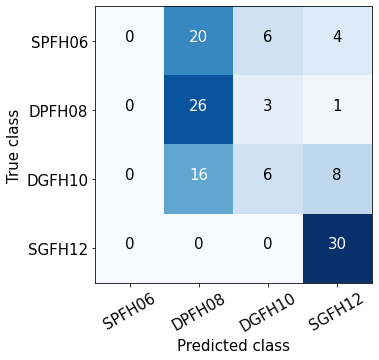

In [ ]:
# Creating targets:
pred_PP = fault_prediction[0:30]
pred_PPG = fault_prediction[30:60]
pred_PG = fault_prediction[60:90]
pred_PPPG = fault_prediction[90:120]
pred_global = np.hstack((pred_PP, pred_PPG, pred_PG, pred_PPPG))
fault_pred = np.array([pred_global], dtype='int')
# Arrays are created following the sorted path npydata_path:
targ_pg = np.zeros((1,30), dtype='int')
targ_pp = np.ones((1,30), dtype='int')
targ_ppg = 2*np.ones((1,30), dtype='int')
targ_pppg = 3*np.ones((1,30), dtype='int')
fault_targ = np.hstack((targ_pp, targ_ppg, targ_pg, targ_pppg))
fault_cm = confusion_matrix(fault_targ.T, fault_pred.T)

# Plotting confusion matrix:
# classes_fault = ('SPFL05','DPFL07','DGFL09', 'SGFL11') # LVS faults
classes_fault = ('SPFH06','DPFH08','DGFH10', 'SGFH12') # HVS faults
fig = plt.figure(figsize=(8,5))
plt.rc('font', size=15) #controls default text size
plot_confusion_matrix(fault_cm, classes_fault, normalize=False)
# fig.savefig(fname = 'confusion_matrix_fis2.eps' ,  bbox_inches='tight')